In [1]:
import os
import pandas as pd
import polars as pl
import excellaint as ea

test_file = "/Users/ct6g18/Python/ExcellAint/test/test_data/2_digit_yr.xlsx"

df = pd.read_excel(test_file)

df["pd_read_dates"] = pd.to_datetime(df["mangled_dates"])

df.iloc[280:295]

/var/folders/r7/qpq_q3zj64nbvr29pvrhky6m0000gq/T/ipykernel_46464/3812195674.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["pd_read_dates"] = pd.to_datetime(df["mangled_dates"])


,mangled_dates,row_id,pd_read_dates
280,12/01/20 04:00,280,2020-12-01 04:00:00
281,12/01/20 05:00,281,2020-12-01 05:00:00
282,12/01/20 06:00,282,2020-12-01 06:00:00
283,12/01/20 07:00,283,2020-12-01 07:00:00
284,12/01/20 08:00,284,2020-12-01 08:00:00
285,12/01/20 09:00,285,2020-12-01 09:00:00
286,12/01/20 10:00,286,2020-12-01 10:00:00
287,12/01/20 11:00,287,2020-12-01 11:00:00
288,13/01/2020 0:00,288,2020-01-13 00:00:00
289,13/01/2020 1:00,289,2020-01-13 01:00:00


It seems to me like the best way to tackle this problem is to first split the string using the datetime_separator. This then gives us separate date and time columns. 

I'm going to ignore anything subsecond for now, because I'd rather focus on the dates, rather than the times - and I think that the dates are more likely to be the source of the error.

In [2]:
print(ea.config)

ExcellAint Configuration:
{   'allow_dayfirst': True,
    'allow_monthfirst': False,
    'allow_yearfirst': True,
    'date_sep': '-',
    'datetime_sep': ' ',
    'day': True,
    'hour': True,
    'minute': True,
    'mode': 'date',
    'month': True,
    'second': True,
    'time_sep': ':',
    'year': True}


In [3]:
colnames_init = df.columns.tolist()[:2]

In [4]:

def split_datetimes(df : pl.DataFrame | pd.DataFrame
                   ,datetime_col : str = "mangled_dates"
                   ,datetime_sep : str = ea.config.datetime_sep
                   ) -> pl.DataFrame:
    """
    Type union between pl.Dataframe and pd.DataFrame should be removed.

    To be honest, I haven't got a particularly good idea as to how this works. I
    copied it from stackoverflow 
    (https://stackoverflow.com/questions/73699500/python-polars-split-string-column-into-many-columns-by-delimiter)
    and it seems to do what I wanted.

    """

    if isinstance(df, pl.DataFrame):
        pass
    elif isinstance(df, pd.DataFrame):
        df = pl.from_pandas(df)
    else:
        raise ValueError("df must be a pandas or polars DataFrame")

    return (
        df
        .with_columns(
            pl.col("mangled_dates").str.split(ea.config.datetime_sep)
                                    .alias("[date,time]"))
        .explode("[date,time]")
        .with_columns(
            ("string_" + pl.arange(0, pl.len()).cast(pl.Utf8).str.zfill(2))
            .over("row_id")
            .alias("col_nm")
        )
        .pivot(
            index=['row_id', 'mangled_dates'],
            values='[date,time]',
            columns='col_nm',
        )
        .rename(
            {
                "string_00": "date_str",
                "string_01": "time_str"
            }
        )
    )


def convert_time(df : pl.DataFrame) -> pl.DataFrame:
    """
    Takes the time column and converts it to a time object.

    This is somewhat less ambiguous than splitting dates up, so I'm going to 
    keep it simple for now so we can resolve the main issue
    """
    return (
        df.with_columns(
            pl.col("time_str")
            .str
            .to_time(f"%H{ea.config.time_sep}%M")
            .alias("Time")
        )
    )

df = split_datetimes(df)

df = convert_time(df)

df

row_id,mangled_dates,date_str,time_str,Time
i64,str,str,str,time
0,"""01/01/20 12:00…","""01/01/20""","""12:00""",12:00:00
1,"""01/01/20 01:00…","""01/01/20""","""01:00""",01:00:00
2,"""01/01/20 02:00…","""01/01/20""","""02:00""",02:00:00
3,"""01/01/20 03:00…","""01/01/20""","""03:00""",03:00:00
4,"""01/01/20 04:00…","""01/01/20""","""04:00""",04:00:00
…,…,…,…,…
17539,"""31/12/2021 19:…","""31/12/2021""","""19:00""",19:00:00
17540,"""31/12/2021 20:…","""31/12/2021""","""20:00""",20:00:00
17541,"""31/12/2021 21:…","""31/12/2021""","""21:00""",21:00:00


In [5]:
ea.config.date_sep = "/"
# This is just a retread of the above, except now using the datetime splitter
def split_dates(df : pl.DataFrame | pd.DataFrame
               ,datetime_col : str = "mangled_dates"
               ,datetime_sep : str = ea.config.datetime_sep
               ) -> pl.DataFrame:
    """
    Type union between pl.Dataframe and pd.DataFrame should be removed.

    To be honest, I haven't got a particularly good idea as to how this works. I
    copied it from stackoverflow 
    (https://stackoverflow.com/questions/73699500/python-polars-split-string-column-into-many-columns-by-delimiter)
    and it seems to do what I wanted.

    """

    if isinstance(df, pl.DataFrame):
        pass
    elif isinstance(df, pd.DataFrame):
        df = pl.from_pandas(df)
    else:
        raise ValueError("df must be a pandas or polars DataFrame")

    return (
        df
        .with_columns(
            pl.col(datetime_col).str.split(ea.config.date_sep)
                                    .alias("[date]"))
        .explode("[date]")
        .with_columns(
            (pl.arange(0, pl.len()))
            .over("row_id")
            .alias("col_nm")
        )
        .pivot(
            index=['row_id', 'mangled_dates','Time'],
# We can make this more robust in the future by working out all the columns other 
# than the column we want to split
            values='[date]',
            columns='col_nm',
        )
    )   

df = split_dates(df,datetime_col="date_str")


### Heres the plan:

From the above, we can clearly see that 'string_00' is a days column, 'string_01' is a months column, and 'string_02' is a years column.

What heuristics am I using to do this? 

- I can see that the dates are all in the range 1-31. 
- I can see that the months are all in the range 1-12.
- Years are a bit secondary, because its not obvious. I'm going to use the heuristic that for years with 4 digits, the first two digits are 19 or 20. For years with 2 digits, the year is in the range 0-99. If the year is 2 digits and less than 24, I'm going to assume that the year is 20xx. If the year is 2 digits and greater than 24, I'm going to assume that the year is 19xx. This is a bit of a guess, but I think it's a reasonable one.

So we first need to get some statistics on our remaining columns to split, and then we need to assign a level of confidence to which are the days, months, and years columns. 

Maaaybe we could come back and use some machine learning stuff for this, but for now I think we can do it manually.

In [6]:
import polars.selectors as cs
import warnings

cols_to_process = [col for col in df.select(cs.by_dtype(pl.Utf8)).columns if col not in colnames_init]

for col in cols_to_process:
    print(col)

# Now we need to get some of the relevant statistics on our columns.

# First thing to do is get the max character width of them all
processing_df = df.select(*cols_to_process)

max_chars_dict = processing_df.with_columns(
    [pl.col(colname).str.len_chars().max() for colname in cols_to_process]
).max().to_dict(as_series=False)

max_chars_dict = {
    key : val[0] if val else None for key,val in max_chars_dict.items()
}


max_val_dict = processing_df.with_columns(
    [pl.col(colname).cast(pl.Int32).max() for colname in cols_to_process]
).max().to_dict(as_series=False)

max_val_dict = {
    key : val[0] if val else None for key,val in max_val_dict.items()
}

def assign_datetype(cols_to_process : list[str]
                   ,max_chars_dict : dict[str,int]
                   ,max_val_dict : dict[str,int]
                   ) -> dict[str,str]:
    """
    This function takes the columns to process, the maximum number of characters
    in each column and the maximum value in each column and returns a dictionary
    of the `date data` types of each column:
        - Year 
        - Month
        - Day
    """
    available_date_data_types = { 
        "Year",
        "Month",
        "Day",
    }

    mappings = {
        "Year" : None,
        "Month" : None,
        "Day" : None,
    }

    for key, val in max_chars_dict.items():
        if val == 4:
            mappings["Year"] = int(key)
            available_date_data_types.remove("Year")

            if not ea.config.allow_monthfirst:
                mappings["Day"] = 2 - mappings["Year"]
                mappings["Month"] = 1

                available_date_data_types.remove("Day")
                available_date_data_types.remove("Month")
                break
            
            else:
                raise NotImplementedError("Only an instance with a four digit year is supported at the moment.")


    if len(available_date_data_types) > 0:
        raise AssertionError(f"Could not assign all date data types. Remaining: {available_date_data_types}. Please check the data.")

    mappings = {str(val) : key for key, val in mappings.items()}

    warnings.warn("Did not use the following arguments: {max_val_dict}, {cols_to_process}."
                  " We probably need to make this function a bit smarter."
                  ,stacklevel=2)

    return mappings
        
mappings = assign_datetype(cols_to_process,max_chars_dict,max_val_dict)

df = df.rename(mappings)

df = df.with_columns(
    pl.col("Day").cast(pl.Int32),
    pl.col("Month").cast(pl.Int32),
)


0
1
2


/var/folders/r7/qpq_q3zj64nbvr29pvrhky6m0000gq/T/ipykernel_46464/1042621908.py:83: UserWarning: Did not use the following arguments: {max_val_dict}, {cols_to_process}. We probably need to make this function a bit smarter.
  mappings = assign_datetype(cols_to_process,max_chars_dict,max_val_dict)


In [7]:

def year_to_int(df : pl.DataFrame
                ,year_col : str = "Year"
                ) -> pl.DataFrame:
    """
    This gets a bit stupid, because we need to generate a new column which is a
    boolean: is the year column four characters. If so, we can cast it to an int.
    If not, we want to check if the two characters we have are less than or equal 
    to the current year. If so, we prepend "20". If not, we prepend "19".
    """

    # Spoof the current year

    CURRENT_YEAR = 24

    df = df.with_columns(
        pl.col("Year").str.len_chars().alias("year_len")
    )

    df = df.with_columns(
        pl.when(pl.col("year_len") == 4)
          .then(pl.col("Year").cast(pl.Int32))
          .otherwise(
            pl.col("Year")
          ).alias("Year")
    )

    df = df.with_columns(
        pl.when(pl.col("year_len") == 2)
        .then(
            pl.when(pl.col("Year").cast(pl.Int32) <= CURRENT_YEAR)
            .then(pl.lit("20"))
            .otherwise(pl.lit("19"))
           )
        .otherwise(pl.lit(""))
        .alias("prepend_col")
    )

    df = df.with_columns(
        (pl.col("prepend_col") + pl.col("Year").alias("Year"))
        .cast(pl.Int32)
        .alias("Year")
    )

    df = df.drop("year_len","prepend_col")

    return df.with_columns(
        pl.col(year_col).cast(pl.Int32)
    )


df = year_to_int(df)

df

row_id,mangled_dates,Time,Day,Month,Year
i64,str,time,i32,i32,i32
0,"""01/01/20 12:00…",12:00:00,1,1,2020
1,"""01/01/20 01:00…",01:00:00,1,1,2020
2,"""01/01/20 02:00…",02:00:00,1,1,2020
3,"""01/01/20 03:00…",03:00:00,1,1,2020
4,"""01/01/20 04:00…",04:00:00,1,1,2020
…,…,…,…,…,…
17539,"""31/12/2021 19:…",19:00:00,31,12,2021
17540,"""31/12/2021 20:…",20:00:00,31,12,2021
17541,"""31/12/2021 21:…",21:00:00,31,12,2021


In [14]:
def combine_date_cols(df : pl.DataFrame) -> pl.DataFrame:
    """
    This function takes a dataframe with date columns and a time column and 
    combines them into a datetime column. Since the names are all set by the 
    previous functions we can keep things really constrained

    """

    df = df.with_columns(
        pl.date(
            pl.col("Year"),
            pl.col("Month"),
            pl.col("Day"),
        ).alias("Date")
        )

    return df

def combine_datetime_cols(df : pl.DataFrame) -> pl.DataFrame:
    """
    Combine our date and our time column
    """

    df = df.with_columns(
        pl.datetime(
            pl.col("Date").dt.year(),
            pl.col("Date").dt.month(),
            pl.col("Date").dt.day(),
            pl.col("Time").dt.hour(),
            pl.col("Time").dt.minute(),
            pl.col("Time").dt.second(),
        ).alias("Datetime")
        )

    df = df.drop("Date","Time","Year","Month","Day")

    return df

df = combine_date_cols(df)
df = combine_datetime_cols(df)

df


row_id,mangled_dates,Datetime
i64,str,datetime[μs]
0,"""01/01/20 12:00…",2020-01-01 12:00:00
1,"""01/01/20 01:00…",2020-01-01 01:00:00
2,"""01/01/20 02:00…",2020-01-01 02:00:00
3,"""01/01/20 03:00…",2020-01-01 03:00:00
4,"""01/01/20 04:00…",2020-01-01 04:00:00
…,…,…
17539,"""31/12/2021 19:…",2021-12-31 19:00:00
17540,"""31/12/2021 20:…",2021-12-31 20:00:00
17541,"""31/12/2021 21:…",2021-12-31 21:00:00


<Axes: >

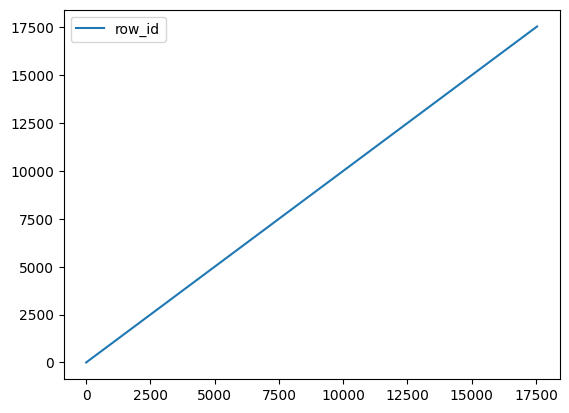

In [12]:
df.to_pandas().plot(y="row_id")

- Long story short - it works in this specific instance. Now we just need to pull out the logic and we can get to business.


- After that - refactoring and speeding things up.